In [1]:
import numpy as np
import pandas as pd
from glob import glob

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

import pylab as plt
%matplotlib inline

import os
os.getcwd()

'/home/yihuang/Documents/CODE/Python_projects/unitcov/forecast_pipeline'

## Get data

In [2]:
with open('pipeline_data/steps.dat', 'r') as handle:
    steps = handle.readline().strip().split()
    
ns = len(steps)

steps_c = [f'case{i}' for i in range(ns)]
steps_d = [f'death{i}' for i in range(ns)]
steps_ = steps_c + steps_d

In [3]:
data_fname = glob('pipeline_data/data_????-??-??.csv')[0]
df = pd.read_csv(data_fname, dtype={'fips': str}).set_index('fips')
# tmp = df[[col for col in df.columns if col.startswith('case') or col.startswith('death')]]
# (tmp < 0).sum()

In [4]:
df['urban_risk'] = df['perc_urban_pop'] * (df['risk_flu'] - df['risk_flu'].min())
covariates = [
    'population', 
    'perc_65yrs', 
    'perc_minority', 
    'perc_black', 
    'perc_hispanic', 
    'perc_poverty', 
    'perc_urban_pop',
    'income',
    'risk_flu',
    'urban_risk'
]

df_z = df[steps_].copy()
for c in covariates:
    mean, std = df[c].mean(), df[c].std()
    df_z[c] = (df[c] - mean) / std
df_z.head()

,case0,case1,case2,case3,case4,case5,case6,case7,case8,case9,...,population,perc_65yrs,perc_minority,perc_black,perc_hispanic,perc_poverty,perc_urban_pop,income,risk_flu,urban_risk
fips,,,,,,,,,,,,,,,,,,,,,
01001,12.0,7.0,6.0,11.0,9.0,23.0,42.0,45.0,61.0,43.0,...,-0.149053,-0.794106,0.512705,0.741329,-0.489703,-0.225017,0.535824,0.480936,1.006875,0.666999
01003,29.0,37.0,43.0,38.0,34.0,35.0,38.0,19.0,10.0,21.0,...,0.349320,0.257409,-0.180113,-0.042334,-0.365711,-0.883379,0.526204,0.353735,1.296454,0.817850
01005,2.0,7.0,9.0,14.0,11.0,15.0,21.0,26.0,45.0,40.0,...,-0.241908,-0.012923,2.192825,2.685016,-0.379632,2.589482,-0.291414,-1.333023,0.420657,-0.240836
01007,4.0,9.0,13.0,8.0,8.0,3.0,5.0,8.0,14.0,5.0,...,-0.248733,-0.647773,0.481481,0.821243,-0.504693,1.091708,-0.310652,-0.483902,0.436170,-0.249735
01009,10.0,2.0,8.0,11.0,9.0,4.0,1.0,4.0,12.0,9.0,...,-0.143225,-0.221003,-0.699751,-0.532156,-0.011632,-0.323771,-1.003223,-0.167862,0.617627,-0.724261


## Get GLM predictions

In [5]:
cov_prefix = 'population+perc_65yrs+perc_minority+perc_black+perc_hispanic+perc_poverty+income+'
cov = cov_prefix + 'perc_urban_pop+risk_flu+urban_risk'

### Case 

In [6]:
cors = []
for i in range(len(steps_c)):
    cur = steps_c[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.1220e+05
Date:                Sat, 07 Nov 2020   Deviance:                   4.1454e+05
Time:                        20:33:37   Pearson chi2:                 7.18e+05
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.0954      0.007    280.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3445e+05
Date:                Sat, 07 Nov 2020   Deviance:                   2.5959e+05
Time:                        20:33:37   Pearson chi2:                 1.12e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5860      0.006    404.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  case8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -70342.
Date:                Sat, 07 Nov 2020   Deviance:                   1.3096e+05
Time:                        20:33:37   Pearson chi2:                 2.42e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5161      0.007    372.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case12   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0517e+05
Date:                Sat, 07 Nov 2020   Deviance:                   1.9863e+05
Time:                        20:33:37   Pearson chi2:                 3.25e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.8696      0.006    478.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case16   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3811e+05
Date:                Sat, 07 Nov 2020   Deviance:                   2.6143e+05
Time:                        20:33:38   Pearson chi2:                 3.54e+05
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6162      0.004    924.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case20   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -83289.
Date:                Sat, 07 Nov 2020   Deviance:                   1.5219e+05
Time:                        20:33:38   Pearson chi2:                 1.88e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4335      0.004    828.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case24   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -95032.
Date:                Sat, 07 Nov 2020   Deviance:                   1.7501e+05
Time:                        20:33:38   Pearson chi2:                 2.57e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.6691      0.004   1006.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 case28   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -97022.
Date:                Sat, 07 Nov 2020   Deviance:                   1.7745e+05
Time:                        20:33:38   Pearson chi2:                 2.18e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0098      0.003   1368.

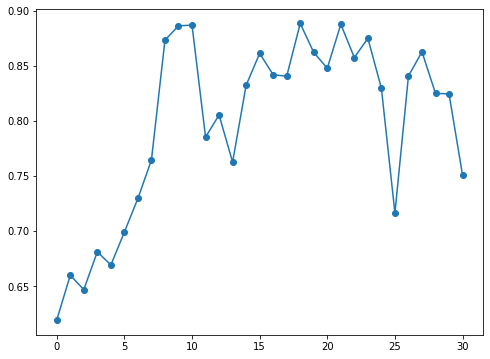

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

### Death

In [8]:
cors = []
for i in range(len(steps_d)):
    cur = steps_d[i]
    formula = f'{cur}~{cov}'

    model = smf.glm(
        formula=formula,
        data=df_z,
        family=sm.families.Poisson(sm.families.links.log())
    ).fit()
    print(f'{model.summary()}\n\n')
    
    prd = model.predict()
    cor = pd.DataFrame(
        data={'prd': prd, 'grd': df_z[cur].values}, 
        index=df.index).corr().loc['prd', 'grd']
    cors.append(cor)
    
    df_z[cur + '_glm'] = model.predict()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death0   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10256.
Date:                Sat, 07 Nov 2020   Deviance:                       18471.
Time:                        20:33:39   Pearson chi2:                 5.64e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -2.3321      0.050    -46.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death4   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11734.
Date:                Sat, 07 Nov 2020   Deviance:                       20732.
Time:                        20:33:39   Pearson chi2:                 3.61e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.7064      0.034    -20.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 death8   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6119.4
Date:                Sat, 07 Nov 2020   Deviance:                       9826.3
Time:                        20:33:40   Pearson chi2:                 2.12e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.8529      0.038    -22.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death14   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4011.0
Date:                Sat, 07 Nov 2020   Deviance:                       5573.5
Time:                        20:33:40   Pearson chi2:                 9.82e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0347      0.040    -25.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death20   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5260.9
Date:                Sat, 07 Nov 2020   Deviance:                       7062.1
Time:                        20:33:41   Pearson chi2:                 9.96e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.4703      0.029    -16.

                 Generalized Linear Model Regression Results                  
Dep. Variable:                death27   No. Observations:                 3094
Model:                            GLM   Df Residuals:                     3083
Model Family:                 Poisson   Df Model:                           10
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4953.8
Date:                Sat, 07 Nov 2020   Deviance:                       6417.4
Time:                        20:33:41   Pearson chi2:                 9.25e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.3143      0.026    -12.

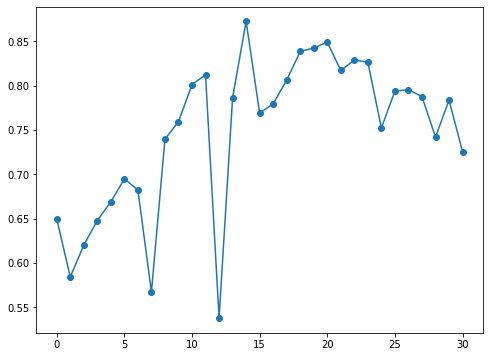

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(cors, marker='o')

In [10]:
df_z.to_csv(data_fname[:-4] + '_glm.csv', float_format='%.2f')

## Validation

In [11]:
cols = [col for col in df_z.columns if (col.startswith('case')) or (col.startswith('death'))]
(df_z[cols] < 0).sum()

case0          0
case1          0
case2          0
case3          0
case4          0
case5          0
case6          0
case7          0
case8          0
case9          0
case10         0
case11         0
case12         0
case13         0
case14         0
case15         0
case16         0
case17         0
case18         0
case19         0
case20         0
case21         0
case22         0
case23         0
case24         0
case25         0
case26         0
case27         0
case28         0
case29         0
              ..
death1_glm     0
death2_glm     0
death3_glm     0
death4_glm     0
death5_glm     0
death6_glm     0
death7_glm     0
death8_glm     0
death9_glm     0
death10_glm    0
death11_glm    0
death12_glm    0
death13_glm    0
death14_glm    0
death15_glm    0
death16_glm    0
death17_glm    0
death18_glm    0
death19_glm    0
death20_glm    0
death21_glm    0
death22_glm    0
death23_glm    0
death24_glm    0
death25_glm    0
death26_glm    0
death27_glm    0
death28_glm   